# Generate Approximate Hessians
Use the random displacement data to get the full Hessian matrix. We assume that many parameters of the Hessian matrix are zero, and therefore that we can fit the Hessian matrix with a reduced number of points using [sparse linear regression](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.model.linear_internals import HarmonicModel
from jitterbug.model.linear_internals import get_model_inputs
from jitterbug.model.linear_internals import get_model_internal_inputs
from sklearn.linear_model import LinearRegression, ElasticNetCV
from ase.vibrations import VibrationsData
from ase.db import connect
from pathlib import Path
from tqdm import tqdm
import numpy as np
import warnings

Configuration

In [153]:
molecule_name = 'ethanol'

method = 'b3lyp'
basis = '6-31g*'
method = 'hf'
basis = 'def2-svpd'
method = 'wb97x-d'
basis = 'cc-pvtz'
step_size: float = 0.005 # Perturbation amount, used as maximum L2 norm
regressor = LinearRegression

Derived

In [154]:
run_name = f'{molecule_name}_{method}_{basis}'
out_dir = Path('data') / 'approx'
db_path = out_dir / f'{run_name}-random-d={step_size:.2e}.db'

## Read in the Data
Get all computations for the desired calculation and the exact solution

In [155]:
with connect(db_path) as db:
    data = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(data)} structures')

Loaded 392 structures


Read in the exact Hessian

In [156]:
with open(f'data/exact/{run_name}-ase.json') as fp:
    exact_vibs = VibrationsData.read(fp)

In [157]:
exact_hess = exact_vibs.get_hessian_2d()
exact_zpe = exact_vibs.get_zero_point_energy()
exact_freqs = exact_vibs.get_frequencies()

## Fit a Hessian with All Data
Fit a model which explains the energy data by fitting a Hessian matrix using compressed sensing (i.e., Lasso).

In [158]:
model = HarmonicModel(reference=data[0], regressor=regressor)
hess_model = model.train(data)

In [159]:
print(f'Trained a model with {len(hess_model.coef_)} terms. {(np.abs(hess_model.coef_) > 1e-7).sum()} are nonzero')

Trained a model with 252 terms. 252 are nonzero


Compare the forces estimated at a zero displacement to the true value

In [160]:
actual_forces = data[0].get_forces()
n_atoms = len(data[0])
to_compute = 3 * n_atoms + 3 * n_atoms * (3 * n_atoms + 1) // 2 + 1
# ohdist = [datum.get_distance(0,1)- data[0].get_distance(0,1) for datum in data]
# ohdist2 = [datum.get_distance(0,2)- data[0].get_distance(0,2) for datum in data]

# enes = [23.06*(datum.get_potential_energy() - data[0].get_potential_energy()) for datum in data]
# pred_enes = [23.06 * ene for ene in hess_model.predict([get_model_internal_inputs(atoms, data[0]) for atoms in data])]
# fig, ax = plt.subplots(figsize=(5,5))
# ax = plt.axes(projection='3d')
# ax.scatter3D(ohdist, ohdist2, enes)


# fig, ax = plt.subplots(figsize=(5,5))
# ax = plt.axes(projection='3d')
# ax.scatter3D(ohdist, ohdist2, pred_enes)



# print(max([pred_ene - ene for pred_ene, ene in zip(pred_enes, enes)]))

In [161]:
# fig, ax = plt.subplots(figsize=(5,5))
# ax.scatter(ohdist2, enes)
# pred_inp = []
# new_pred_ohdists = []
# for i in range(50):
#     disp = np.random.normal(0, 1, size=(len(data[0]) * 3))
#     disp /= np.linalg.norm(disp)
#     disp *= step_size#*random.randint(20,100)/100
#     disp = disp.reshape((-1, 3))
    
#     # Subtract off any translation
#     disp -= disp.mean(axis=0)[None, :]

#     # Make the new atoms
#     new_atoms = data[0].copy()
#     new_atoms.positions += disp
#     pred_inp.append(get_model_internal_inputs(new_atoms, data[0]))
#     new_pred_ohdists.append(new_atoms.get_distance(0,1)- data[0].get_distance(0,1))
# new_pred_enes = hess_model.predict(pred_inp)
# new_pred_enes = [23.06 * ene for ene in new_pred_enes]
# ax.scatter(new_pred_ohdists, new_pred_enes)
# ax.set_xlabel('O-H displacement')
# ax.set_ylabel('energy')

In [162]:
pred_forces = -hess_model.coef_[:actual_forces.size].reshape((-1, 3))

In [163]:
print(f'Maximum force: {np.abs(pred_forces).max():.2e} eV/Angstrom')

Maximum force: 7.72e+00 eV/Angstrom


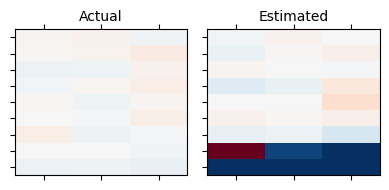

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Actual', 'Estimated'], [actual_forces, pred_forces]):
    ax.matshow(h, vmin=-0.05, vmax=0.05, aspect='auto', cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the mean Hessian

In [165]:
approx_hessian = model.mean_hessian(hess_model, data[0])

Compare to exact answer

In [166]:
exact_hess

array([[ 2.69016123e+01, -1.28458641e+01,  3.36727325e+00,
        -1.75307484e+01,  6.39414201e+00, -2.70410023e+00,
        -4.19781009e+00,  3.00911307e+00,  1.25621745e-01,
        -1.14264833e+00,  1.42416326e+00, -4.30216652e-01,
        -5.63190896e-01,  7.06647583e-01,  3.20462967e-01,
        -7.98375929e-01, -5.05108226e-01, -1.69079269e-02,
         3.14585947e-01,  8.25866188e-02,  6.18862724e-02,
         3.16352059e-01,  7.63867259e-02, -1.20350918e-01,
        -3.29609746e+00,  1.67639180e+00, -6.03636525e-01],
       [-1.28458641e+01,  3.22899398e+01,  2.49678233e+01,
         9.11507477e+00, -1.27669506e+01,  2.98634995e-01,
        -5.71854182e-01,  1.02078058e+00, -1.90378639e-01,
         2.81137569e+00, -1.75327349e+00,  1.13238325e-01,
         2.46104075e+00, -1.69009254e+00, -1.50141065e-01,
        -3.27459074e-01, -2.68044395e-03,  3.97006717e-02,
         1.67374426e-01,  2.15847540e-01, -1.53605712e-01,
         4.22478642e-02,  1.91686322e-01,  1.57457938e-

In [167]:
approx_hessian

array([[ 2.11405025e+01, -8.60117469e+00,  1.98456240e+00,
        -1.49581689e+01,  6.24037908e+00, -3.37047553e-01,
        -5.92642497e-01,  2.24208812e+00, -8.22656112e-01,
        -8.01653930e-01,  2.28371228e+00, -7.50621434e-01,
        -2.29629323e-01, -2.73036037e-01,  4.62198484e-01,
        -6.25443179e-01, -2.99036124e-01, -3.75883120e-01,
        -1.14666995e-01,  2.59019461e-02,  1.54814119e-01,
        -1.49487629e-01, -8.64297140e-01,  4.01571181e-02,
        -3.66881005e+00, -7.54537437e-01, -3.55523900e-01],
       [-8.60117469e+00,  3.23457628e+01,  1.82862885e+01,
         1.00617886e+01, -6.47868064e+00,  1.87805113e+00,
         5.07962511e+00,  2.53488163e+00, -5.78225482e-01,
         2.27159773e+00, -2.03292514e+00, -3.56464824e-01,
        -7.00018065e-01, -4.46205877e+00, -4.67939194e-01,
        -1.96916594e+00, -4.93330360e-02,  1.06502693e+00,
        -3.63511080e-01, -1.73577776e+00, -2.62997909e-01,
        -2.23436936e+00,  1.49083427e-01, -1.64288333e+

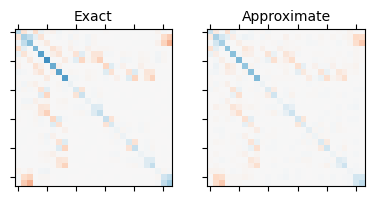

In [168]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Exact', 'Approximate'], [exact_hess, approx_hessian]):
    ax.matshow(h, vmin=-100, vmax=100, cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)
fig.tight_layout()

Get the zero point energy

In [169]:
approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
print(np.linalg.eigh(approx_hessian)[0])
print(np.linalg.eigh(exact_hess)[0])
print(exact_freqs)
print(approx_vibs.get_frequencies())

[-3.89983883e-04 -1.71867556e-04 -7.11394971e-15  5.82848976e-15
  1.34448773e-14  7.99332376e-04  8.04244488e-01  1.45362418e+00
  2.43120869e+00  3.08677324e+00  4.06079173e+00  5.92410416e+00
  7.23141473e+00  1.14192054e+01  1.26521469e+01  1.66491206e+01
  1.73611874e+01  1.75412399e+01  1.90691724e+01  2.45390967e+01
  4.23310191e+01  5.51917811e+01  5.95863497e+01  6.11185120e+01
  6.18334255e+01  6.26709710e+01  8.90542797e+01]
[-1.55611349e-02 -4.26253757e-03 -2.19885489e-03 -7.28129306e-04
 -5.16033228e-04  1.82275255e-04  2.43419510e-01  4.48980314e-01
  2.30045175e+00  3.02202121e+00  5.09296039e+00  6.52143862e+00
  8.10341616e+00  8.87163034e+00  1.07894181e+01  1.17285537e+01
  1.48030541e+01  1.73621694e+01  2.01483364e+01  2.78245586e+01
  5.03103274e+01  6.65487612e+01  7.56938035e+01  7.85362795e+01
  8.40871890e+01  8.81908576e+01  1.12628340e+02]
[0.00000000e+00+42.52946942j 0.00000000e+00+23.69312092j
 0.00000000e+00+11.70107322j 0.00000000e+00 +6.20558433j
 0.000

In [170]:
approx_vibs.get_zero_point_energy()

2.107328812193435

In [171]:
exact_zpe

2.1884190925383207

The two differ, but I'm not sure how important the difference is.

In [172]:
freq_diff = [app_freq.real-ex_freq.real for app_freq, ex_freq in zip(approx_vibs.get_frequencies(), exact_freqs)]

/lcrc/project/PACC/conda/elliott/miniconda3/envs/jitterbug/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


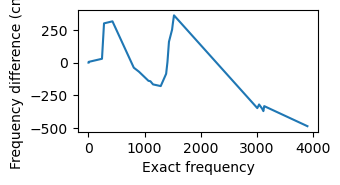

In [173]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(exact_freqs, freq_diff)

ax.set_xlabel('Exact frequency')
ax.set_ylabel('Frequency difference (cm-1)')

fig.tight_layout()

## Plot as a Function of Data
See what happens as we add more data to the training

In [174]:
interval = 10
steps = np.linspace(5, len(data), int(len(data)/interval), dtype=int)
print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')

Plotting at 39 steps: 5, 15, 25, 35, 45, ...


In [175]:
all_zpes = []
all_freqs = []
all_freq_diffs = []
all_steps = []

step_sizes = [0.005]
step_sizes = [0.002, 0.004, .0045, 0.005, 0.0055, .0056, .0057, 0.006, .008, 0.01, .04]
step_sizes = [.002, 0.0045, 0.005, 0.01]
step_sizes = [0.005]
interval = 20
#for step_size in [0.005]:
#for step_size in [0.002, 0.004, .0045, 0.005, 0.0055, .0056, .0057, 0.006, .008, 0.01, .04]:
for step_size in step_sizes:
    zpes = []
    freqs = []
    freq_diffs = []
    db_path = out_dir / f'{run_name}-random-d={step_size:.2e}.db'
    with connect(db_path) as db:
        data = [a.toatoms() for a in db.select('')]
    steps = np.linspace(50, len(data), int(len(data)/interval), dtype=int)
    print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')
    for count in tqdm(steps):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            hess_model = model.train(data[:count])
            approx_hessian = model.mean_hessian(hess_model, data[0])
            approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
            zpes.append(approx_vibs.get_zero_point_energy()*23.060541945329334)
            freqs.append(approx_vibs.get_frequencies())
            freq_diffs.append([app_freq.real-ex_freq.real for app_freq, ex_freq in zip(approx_vibs.get_frequencies(), exact_freqs)])
    all_zpes.append(zpes)
    all_freqs.append(freqs)
    all_freq_diffs.append(freq_diffs)
    all_steps.append(steps)

Plotting at 19 steps: 50, 69, 88, 107, 126, ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:32<00:00,  1.69s/it]


Plot it

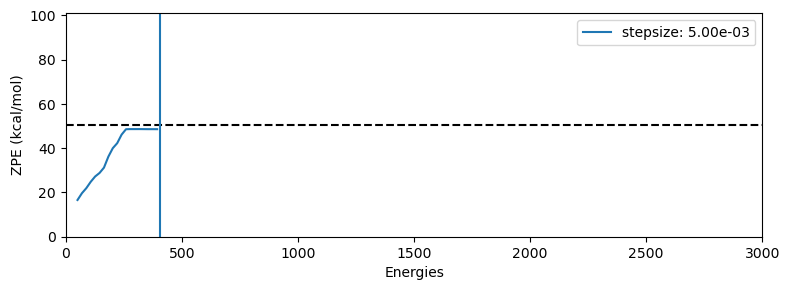

In [176]:
import matplotlib.pylab as pl
max_steps = 0  
fig, ax = plt.subplots(figsize=(8, 3))
for zpes, sizes, steps in zip(all_zpes, step_sizes, all_steps):
   
    if steps[-1] > max_steps:
        max_steps = steps[-1]
    ax.plot(steps, zpes, label='stepsize: {:.2e}'.format(sizes))

ax.set_xlim([0, 3000])
ax.plot(ax.get_xlim(), [exact_zpe*23.060541945329334]*2, 'k--')
plt.axvline(x=to_compute)
ax.set_ylim([0,exact_zpe*23.060541945329334*2])
ax.set_xlabel('Energies')
ax.set_ylabel('ZPE (kcal/mol)')
ax.legend()
fig.tight_layout()


We consistently underestimate the ZPE. Is it because we have too few oscillators?

/lcrc/project/PACC/conda/elliott/miniconda3/envs/jitterbug/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


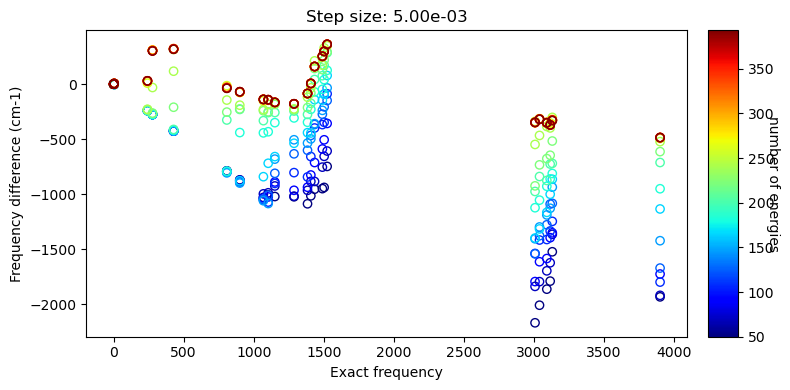

In [177]:
import matplotlib.pylab as pl
import matplotlib
for freq_diffs, sizes, steps in zip(all_freq_diffs, step_sizes, all_steps):
    start=0
    end=200
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [20, 1]})
    colors = pl.cm.jet(np.linspace(0,1,len(freq_diffs[start:end])))

    for i, freq_diff in enumerate(freq_diffs[start:end]):
        plot = axs[0].scatter(exact_freqs, freq_diff, color=colors[i], marker='o', facecolor='none') 
    axs[0].set_xlabel('Exact frequency')
    axs[0].set_ylabel('Frequency difference (cm-1)')
    axs[0].set_title('Step size: {:.2e}'.format(sizes))
    cmap = matplotlib.cm.jet
    norm = matplotlib.colors.Normalize(vmin=steps[start], vmax=steps[i])

    cb1 = matplotlib.colorbar.ColorbarBase(axs[1], cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    cb1.set_label('number of energies', rotation=270)
    fig.tight_layout()


Step sizes 0.005
Max Deviation (cm-1) 361.83485295182095
Mean Absolute Deviation (cm-1) 176.36908124015793
Mean Deviation (cm-1) -48.42908414826238


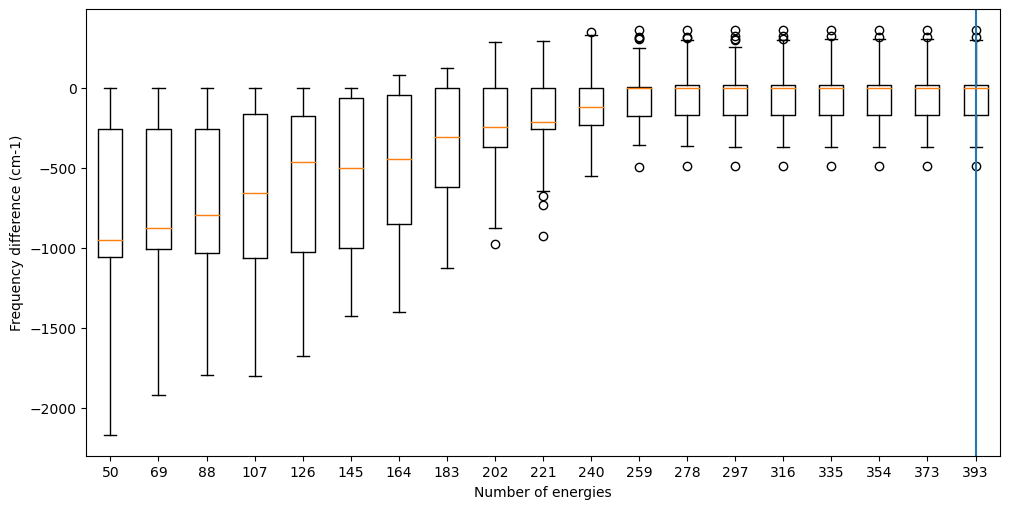

In [178]:
    for freq_diffs, sizes, steps in zip(all_freq_diffs, step_sizes, all_steps):
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.boxplot(freq_diffs)
        for i, val in enumerate(steps):
            if val > to_compute:
                break
        plt.axvline(x=i+1)
        fig.tight_layout()
        ax.set_xticklabels(steps)
        ax.set_xlabel('Number of energies')
        ax.set_ylabel('Frequency difference (cm-1)')
        print("Step sizes", sizes)
        print("Max Deviation (cm-1)", max(freq_diffs[-1]))
        print("Mean Absolute Deviation (cm-1)", sum([abs(freq) for freq in freq_diffs[-1]])/len(freq_diffs[-1]))
        print("Mean Deviation (cm-1)", sum(freq_diffs[-1])/len(freq_diffs[-1]))